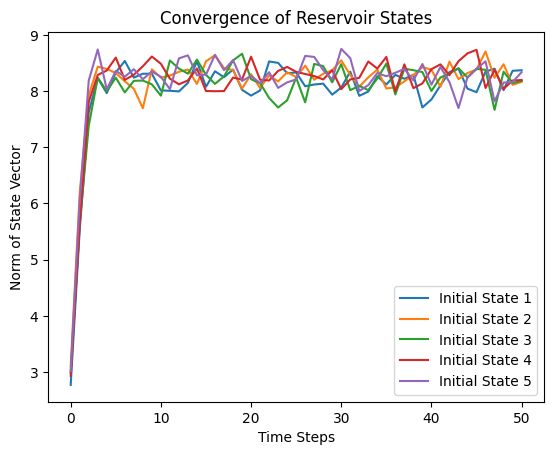

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming a simple reservoir setup
def reservoir_update(W, Win, res_state, input_signal):
    return np.tanh(np.dot(W, res_state) + np.dot(Win, input_signal))

# Example parameters
num_units = 100
W = np.random.rand(num_units, num_units) - 0.5
Win = np.random.rand(num_units, 1) - 0.5
input_signal = np.random.rand(1) - 0.5
time_steps = 50

# Initial states
initial_states = [np.random.rand(num_units) - 0.5 for _ in range(5)]
reservoir_states = [initial_states.copy()]

for t in range(time_steps):
    next_states = []
    for state in reservoir_states[-1]:
        next_state = reservoir_update(W, Win, state, input_signal)
        next_states.append(next_state)
    reservoir_states.append(next_states)

# Plotting convergence of states
for i, state_trajectory in enumerate(zip(*reservoir_states)):
    plt.plot([np.linalg.norm(state) for state in state_trajectory], label=f'Initial State {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Norm of State Vector')
plt.legend()
plt.title('Convergence of Reservoir States')
plt.show()

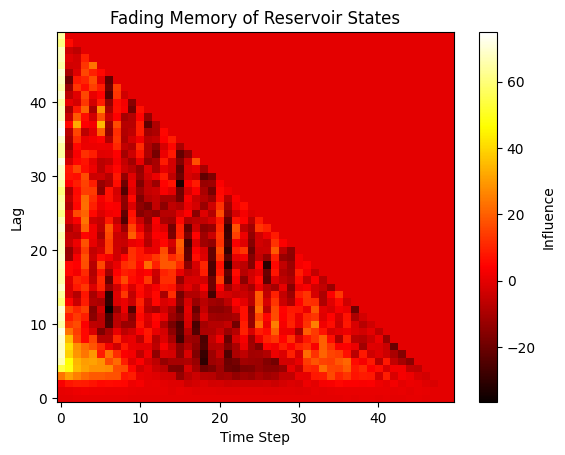

In [2]:
# Generating a structured input sequence
input_sequence = np.sin(np.linspace(0, 10, time_steps)) + np.random.normal(0, 0.1, time_steps)
res_state = np.zeros(num_units)
reservoir_states = []

for t in range(time_steps):
    input_signal = np.array([input_sequence[t]])
    res_state = reservoir_update(W, Win, res_state, input_signal)
    reservoir_states.append(res_state)

# Plotting the influence of past inputs
influence_matrix = np.zeros((time_steps, time_steps))
for t in range(time_steps):
    for tau in range(time_steps - t):
        influence_matrix[t, tau] = np.dot(reservoir_states[t], reservoir_states[t + tau])

plt.imshow(influence_matrix, aspect='auto', cmap='hot', origin='lower')
plt.colorbar(label='Influence')
plt.xlabel('Time Step')
plt.ylabel('Lag')
plt.title('Fading Memory of Reservoir States')
plt.show()

Running ESN-7: 100%|██████████| 1/1 [00:00<00:00, 296.84it/s]


Fitting node ESN-7...


Running ESN-7: 100%|██████████| 1/1 [00:00<00:00, 723.03it/s]


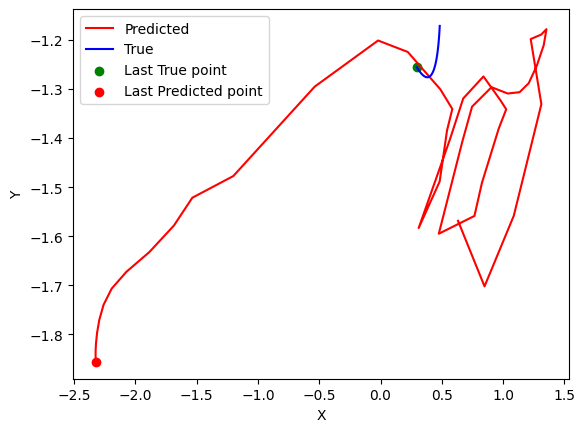

In [17]:
import pandas as pd
from reservoirpy.nodes import Reservoir, Ridge, ESN
from reservoirpy.datasets import to_forecasting
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("3BP_0.csv")
X = df[['x','y', 'vx', 'vy']].values

# scale the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

n = int(len(X) * 0.8)

variables = 4

x, y = to_forecasting(X, forecast=1)
X_train1, y_train1 = x[:n], y[:n]
X_test1, y_test1 = x[n:], y[n:]

units = 1000
leak_rate = 0.8
spectral_radius = 0.9
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                  lr=leak_rate, rc_connectivity=connectivity,
                  input_connectivity=input_connectivity)

readout = Ridge(variables, ridge=regularization)

esn = ESN(reservoir=reservoir, readout=readout, workers=-1)

# train the ESN
esn.fit(X_train1, y_train1)

seed_timesteps = 100

warming_inputs = X_test1[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)

nb_generations = 100

X_gen = np.zeros((nb_generations, variables))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

X_t = X_test1[seed_timesteps: nb_generations + seed_timesteps]

# Plot the predicted trajectory
plt.plot(X_gen[:, 0], X_gen[:, 1], 'r')
plt.plot(X_t[:, 0], X_t[:, 1], 'b')
# plot a point in the last position
plt.scatter(X_t[-1, 0], X_t[-1, 1], c='g')
plt.scatter(X_gen[-1, 0], X_gen[-1, 1], c='r')
plt.legend(['Predicted', 'True', 'Last True point', 'Last Predicted point'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
